In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/glove.twitter.27B.200d.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/glove.840B.300d.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/paragram_300_sl999.gensim
/kaggle/input/gensim-embeddings-dataset/glove.840B.300d.gensim
/kaggle/input/gensim-embeddings-dataset/glove.twitter.27B.200d.gensim
/kaggle/input/gensim-embeddings-dataset/numberbatch-en.gensim
/kaggle/input/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim
/kaggle/input/gensim-embeddings-dataset/numberbatch-en.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/crawl-300d-2M.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/crawl-300d-2M.gensim
/kaggle/input/gensim-embeddings-dataset/paragram_300_sl999.gensim.vectors.npy
/kaggle/input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec
/kaggle/input/quora-insincere-questions-classification/trai

# **IMPORTING DEPENDENCIES**

In [2]:
# import libraries useful for the entire module
import pandas as pd 
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import string


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
from plotly import tools
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from wordcloud import WordCloud,STOPWORDS


# nltk library
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn library
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline,manifold

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve


# models from sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.manifold import TSNE


# other required modules
from collections import defaultdict
from collections import Counter
%matplotlib inline


# **SETTING UP DATA**

In [3]:
train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print(train_df.head())
print(test_df.head())
print("===========")
print("Training Shape".format(),train_df.shape)
print("Testing Shape".format(),test_df.shape)

                    qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
                    qid                                      question_text
0  0000163e3ea7c7a74cd7  Why do so many women become so rude and arroga...
1  00002bd4fb5d505b9161  When should I apply for RV college of engineer...
2  00007756b4a147d2b0b3  What is it really like to be a nurse practitio...
3  000086e4b7e1c7146103                             Who are entrepreneurs?
4  0000c4c3fbe8785a3090   Is education really making good people nowadays?
Training 

In [4]:
print("The type of columns in the dataset")
print("Columns".format(),train_df.columns)

The type of columns in the dataset
Columns Index(['qid', 'question_text', 'target'], dtype='object')


In [5]:
train_ext=train_df[train_df['target']==1]['question_text']
print(train_ext)

22         Has the United States become the largest dicta...
30         Which babies are more sweeter to their parents...
110        If blacks support school choice and mandatory ...
114        I am gay boy and I love my cousin (boy). He is...
115                     Which races have the smallest penis?
                                 ...                        
1306093    How is it to have intimate relation with your ...
1306094    Why is it when singers have lyrics about voice...
1306099                    Do pakis smell of curry and shit?
1306103    Isn't Trump right after all? Why should the US...
1306112                  Are you ashamed of being an Indian?
Name: question_text, Length: 80810, dtype: object


# Training data statistics

### Plot the amount of questions from either types

In [6]:
#Estimate the value counts
count_types=train_df['target'].value_counts()

print("Extracting counts\n" + str(count_types))
#Count targets with value 1

count_ones=train_df[train_df['target']==1].shape[0]
print(count_ones)
count_zeros=train_df[train_df['target']==0].shape[0]
print(count_zeros)


Extracting counts
0    1225312
1      80810
Name: target, dtype: int64
80810
1225312


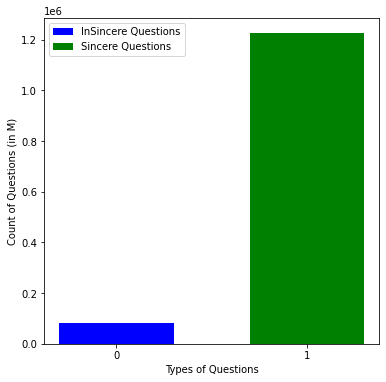

In [7]:
def plot_counts(count_ones,count_zeros):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_ones,width=0.6,label='InSincere Questions',color='Blue')
    plt.legend()
    plt.bar(1,count_zeros,width=0.6,label='Sincere Questions',color='Green')
    plt.legend()
    plt.ylabel('Count of Questions (in M)')
    plt.xlabel('Types of Questions')
    plt.xticks([0,1])
    plt.show()
    

plot_counts(count_ones,count_zeros)

### **Plot for analysing the length of a question sentence**

Length of each insincere questions
 22     11
30     15
110    15
114    34
115     6
Name: question_text, dtype: int64
Length of each sincere questions
 0    13
1    16
2    10
3     9
4    15
Name: question_text, dtype: int64


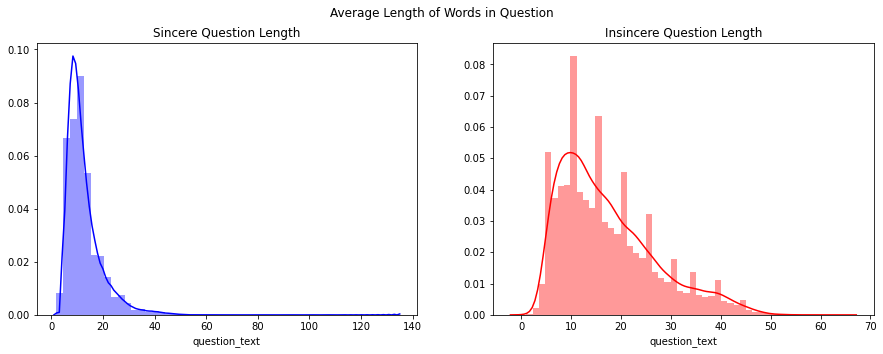

In [8]:
   
def plot_wordcount(count_ones_length,count_zeros_length):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros_length,ax=ax1,color='Blue')
    ax1.set_title('Sincere Question Length')
    sns.distplot(count_ones_length,ax=ax2,color='Red')
    ax2.set_title('Insincere Question Length')
    fig.suptitle('Average Length of Words in Question')
    plt.show()    
    

def word_length(x):
    return len(x)

# count_ones_length contains length of question corresponding to every tuple that has y label = 1 '
# split the sentences into a list and 
count_ones_length=train_df[train_df['target']==1]['question_text'].str.split().apply(lambda z:word_length(z))
print("Length of each insincere questions\n".format(),count_ones_length.head())

# count_ones_length contains length of question corresponding to every tuple that has y label = 1 
count_zeros_length=train_df[train_df['target']==0]['question_text'].str.split().apply(lambda z: word_length(z))
print("Length of each sincere questions\n".format(),count_zeros_length.head())
plot_wordcount(count_ones_length,count_zeros_length)

### Plotting number of punctuations in each type of data 

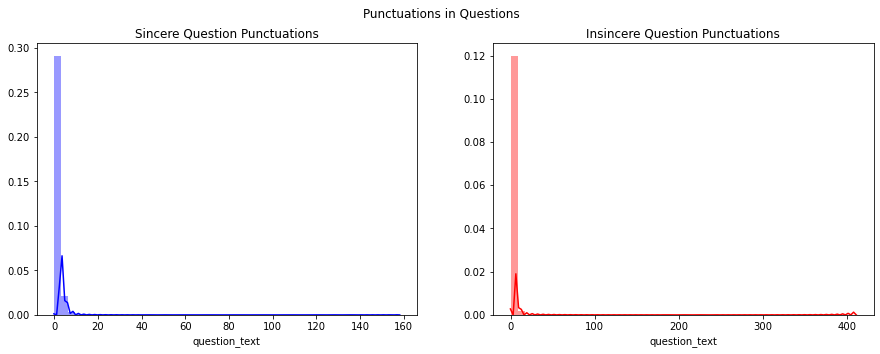

In [9]:

def plot_count(count_punct_ones,count_punct_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_punct_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_punct_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    

count_punct_ones=train_df[train_df['target']==1]['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
count_punct_zeros=train_df[train_df['target']==0]['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
title_1='Sincere Question Punctuations'
title_2='Insincere Question Punctuations'
subtitle='Punctuations in Questions'
plot_count(count_punct_ones,count_punct_zeros,title_1,title_2,subtitle)

### **Preliminary word cloud statistics for training data**


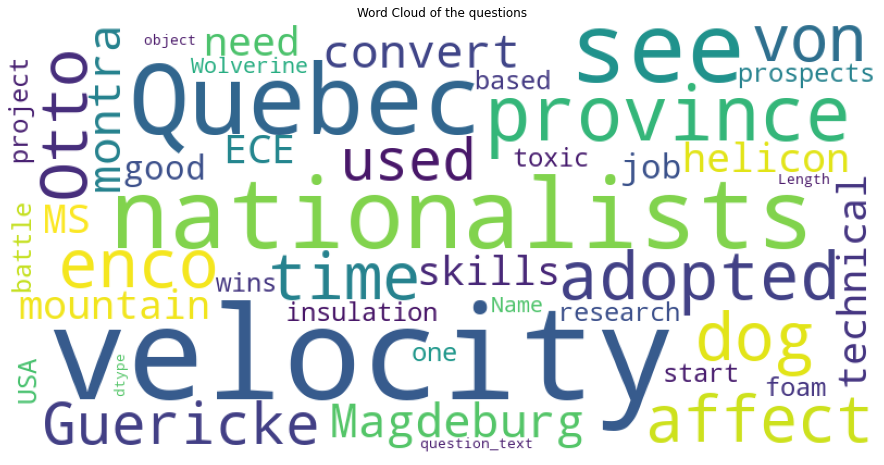

In [10]:

def display_cloud(data):
    stopwords=set(STOPWORDS)
    wordcloud=WordCloud(stopwords=stopwords,max_font_size=120,max_words=300,width=800,height=400,background_color='white',min_font_size=5).generate(str(data))
    plt.figure(figsize=(24,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Word Cloud of the questions")
    plt.show()

display_cloud(train_df['question_text'])

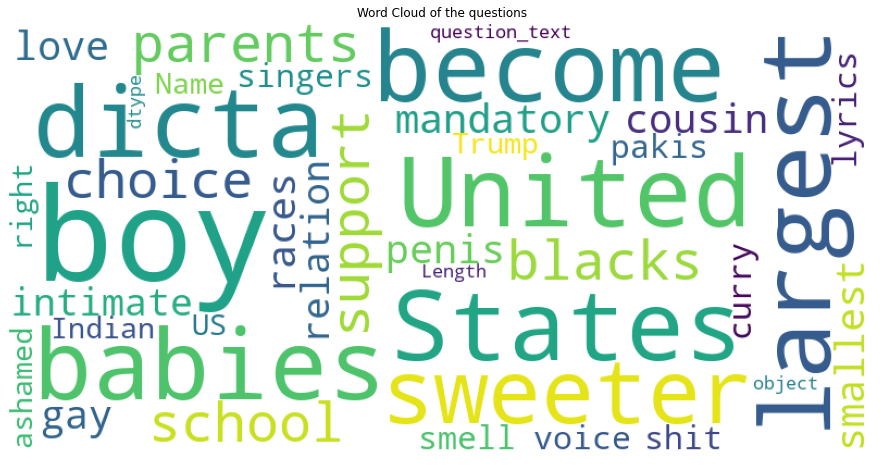

In [11]:
display_cloud(train_df[train_df['target']==1]['question_text'])

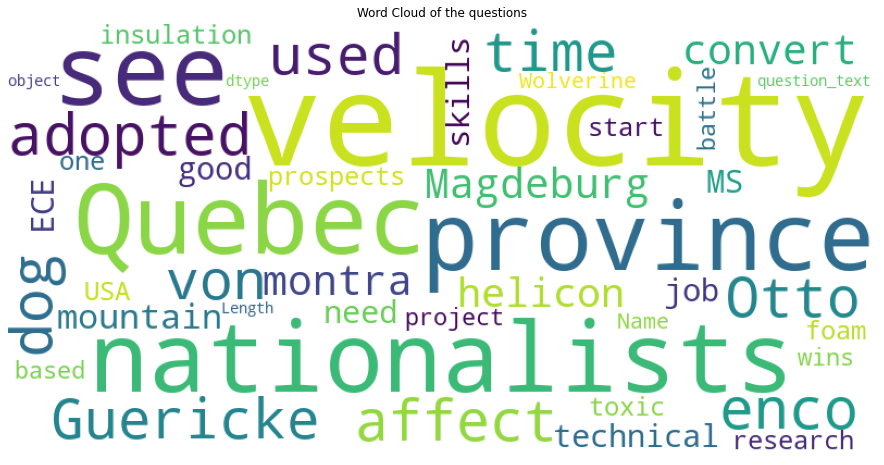

In [12]:
display_cloud(train_df[train_df['target']==0]['question_text'])

# Test data statistics

### **Preliminary word cloud statistics for test data**


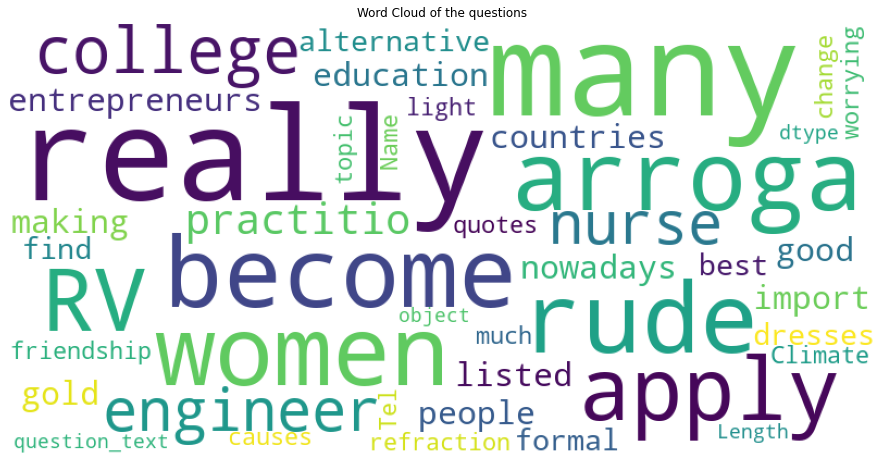

In [13]:
# cloud plot of test data

display_cloud(test_df['question_text'])

### **Plotting number of punctuations in test data**

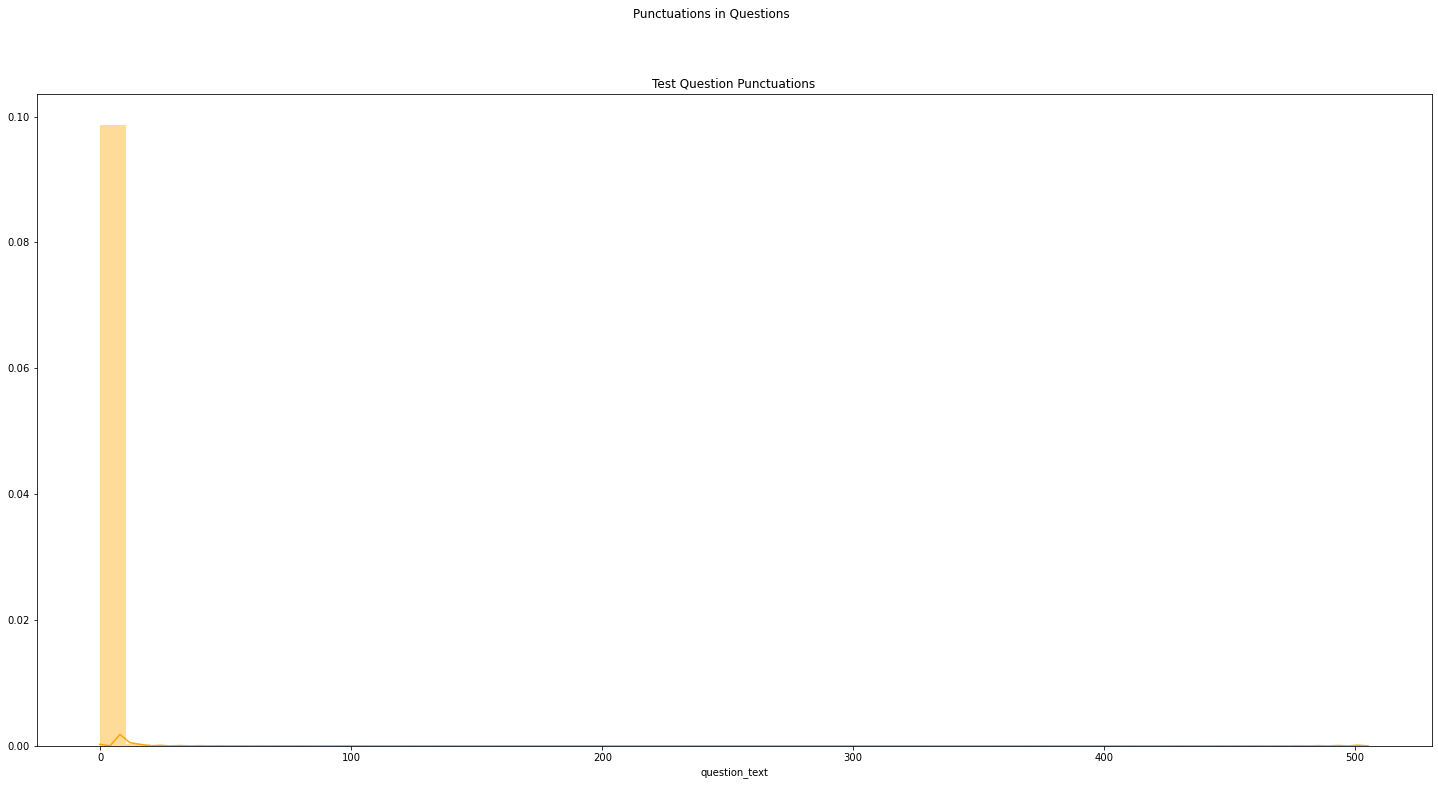

In [14]:
# the method inside apply function is similar to the following code:
# punc = list()
# for x in 'a,b,cd@asadd@':
#     if x in string.punctuation:
#         punc.append(x)
#        
# print(len(punc))

def plot_testcount(count_test,title1,subtitle):
    fig,(ax1)=plt.subplots(1,figsize=(25,12))
    sns.distplot(count_test,ax=ax1,color='Orange')
    ax1.set_title(title_1)
    fig.suptitle(subtitle)
    plt.show()    
    
stops=set(stopwords.words('english'))
count_puncttest=test_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
title_1='Test Question Punctuations'
subtitle='Punctuations in Questions'
plot_testcount(count_puncttest,title_1,subtitle)


### **Plotting the distribution of length of sentences in the test data**


0    21
1    30
2    10
3     3
4     7
5     9
6     6
7    12
8    24
9     8
Name: question_text, dtype: int64


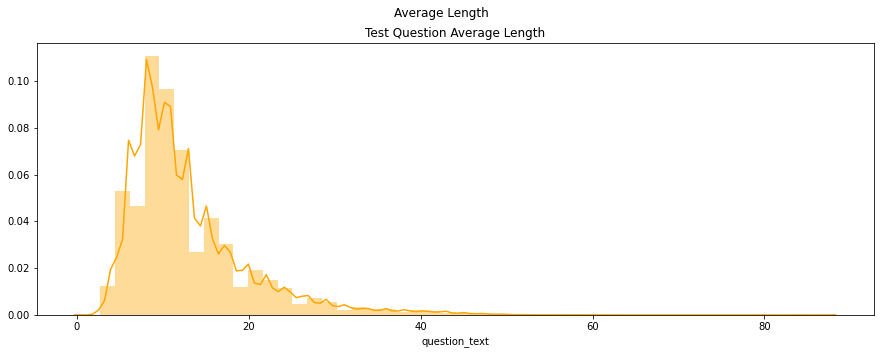

In [15]:
def plot_testcount(count_test,title1,subtitle):
    fig,(ax1)=plt.subplots(1,figsize=(15,5))
    sns.distplot(count_test,ax=ax1,color='Orange')
    ax1.set_title(title_1)
    fig.suptitle(subtitle)
    plt.show()    
    
count_avg_test=test_df['question_text'].str.split().apply(lambda z : len(z))
print(count_avg_test.head(10))
title_1='Test Question Average Length'
subtitle='Average Length'
plot_testcount(count_avg_test,title_1,subtitle)

# **GRAM ANALYSIS**

### **BASIC GRAM ANALYSIS FROM SCRATCH**

Bi-gram analysis
   n_gram_words  n_gram_frequency
0      best way              6973
1  would happen              3350
2      year old              2972
3       get rid              2317
4     feel like              2274
    n_gram_words  n_gram_frequency
0   donald trump              1076
1   white people               673
2   black people               652
3    many people               383
4  united states               360


/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Tri-gram analysis
            n_gram_words  n_gram_frequency
0      advice would give               914
1        what's best way               832
2  tips someone starting               716
3  someone starting work               713
4    useful tips someone               713
           n_gram_words  n_gram_frequency
0    black lives matter                42
1           kim jong un                36
2           12 year old                35
3  people still believe                33
4           14 year old                33


/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



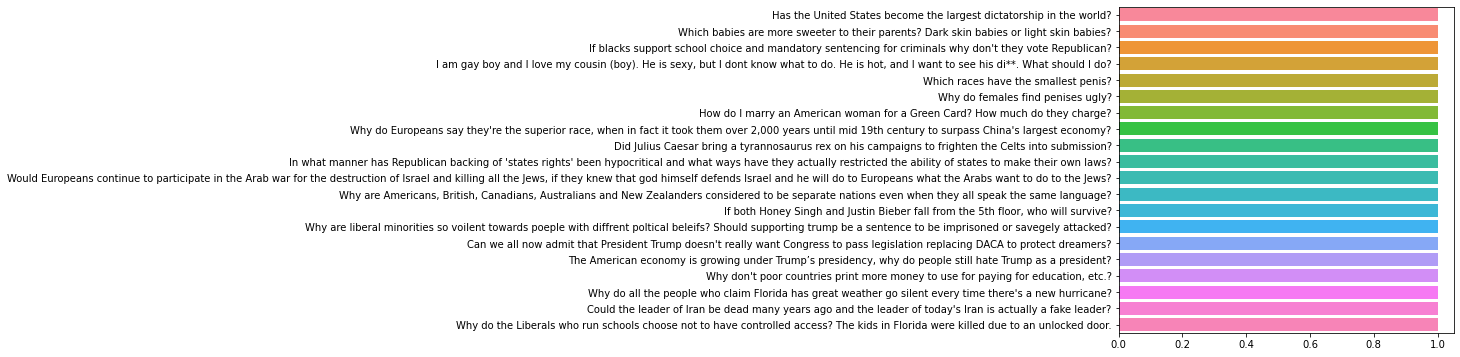

In [16]:


stopword=set(stopwords.words('english'))


# step 1: 
# I need the question texts for labels 1 and 0

train_df_zero=train_df[train_df['target']==0]['question_text']
train_df_ones=train_df[train_df['target']==1]['question_text']


# step 2: 
# gram analysis function

# ********** Line by line explanation *******

# 2.1 : >>>tokens=[t for t in data.lower().split(" ") if t!="" if t not in stopword]
#
#       for every question text in the data, first check whether the word is not a stopword. If it is not, append the word to a list called tokens

# 2.2 : >>>ngrams=zip(*[tokens[i:] for i in range(gram)])  
#       >>>final_tokens=[" ".join(z) for z in ngrams]
#       
#         --->  [tokens[i:] for i in range(gram)] 
#                    returns a list of the format : [tokens[0:] , tokens[1:]] where each element is a list itself
#                 
#                    sample output : [['quebec', 'nationalists', 'see', 'province', 'nation', '1960s?'], ['nationalists', 'see', 'province', 'nation', '1960s?']]
#
#         --->  ngrams = zip(*[tokens[i:] for i in range(gram)])
#                    
#                    zip wants a bunch of arguments to zip together, but what you have is a single argument (a list, whose elements are also lists). The * in a function
#                    call "unpacks" a list (or other iterable), making each of its elements a separate argument. zip function returns a zip object. For example:
#                    >>> p = [[1,2,3],[4,5,6]]
#                    >>> d=zip(*p)
#                    >>> list(d)
#                    o/p: [(1, 4), (2, 5), (3, 6)]

#         --->  final_tokens = [" ".join(z) for z in ngrams]
#                    
#                    creates a list out of the zip object        
#                    sample output : ['quebec nationalists', 'nationalists see', 'see province', 'province nation', 'nation 1960s?']

#Gram analysis on Training set
def gram_analysis(data,gram):
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stopword]
    # print("Tokens:\n" + str([tokens[i:] for i in range(gram)]))
    ngrams=zip(*[tokens[i:] for i in range(gram)])  # ngrams will be a zip object
    final_tokens=[" ".join(z) for z in ngrams]
    # print("final tokens\n" + str(final_tokens))
    return final_tokens


# step 3: 
# create a counter dictionary for every n-gram pair created from the entire dataset so the dictionary will have the ngram pair as the key and no. of times that
# ngram pair occured in the entire data set as the value

#Create frequency grams for analysis
def create_dict(data,grams):
    freq_dict=defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence,grams):
            freq_dict[tokens]+=1
    #print("dict\n" + str(freq_dict))
    #print("\n\n\ndict items \n" + str(freq_dict.items()))
    return freq_dict



# step 4:
#  now we sort the freq dict created above using in decreasing order of the n gram count using code:
#  freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1]) where freq_dict.items() returns tuple of this kind: ('united states', 1) and we sort on basis of
#  the count value done by the code: key=lambda z:z[1] in the function

#  we return a plot object called trace

def create_new_df(freq_dict):
    freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns=['n_gram_words','n_gram_frequency']
    print(freq_df.head())
    #plt.barh(freq_df['n_gram_words'][:20],freq_df['n_gram_frequency'][:20],linewidth=0.3)
    #plt.show()
    trace=horizontal_bar_chart(freq_df[:20],'blue')
    return trace

# step 5:
#  This functions plots the trace object of n grams of data where label = 1 and of data where label = 0 seperately in a figure

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

def plot_grams(trace_zero,trace_one):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
    fig.append_trace(trace_zero, 1, 1)
    fig.append_trace(trace_ones, 1, 2)
    fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')





# Step 6 - additional analysis: 
#          Analyse most common Sentences

def mostcommon_words(data):
    counter=Counter(data)
    commonwords=counter.most_common()
    x_coord,y_coord=[],[]
    for words,occ in commonwords[:20]:
        if words not in stopword:
            x_coord.append(occ)
            y_coord.append(words)
            
    sns.barplot(x=x_coord,y=y_coord,saturation=1,orient="h")


    
    
    
print("Bi-gram analysis")

freq_train_df_zero=create_dict(train_df_zero,2)
trace_zero=create_new_df(freq_train_df_zero)

freq_train_df_ones=create_dict(train_df_ones,2)
trace_ones=create_new_df(freq_train_df_ones)

plot_grams(trace_zero,trace_ones)

print("Tri-gram analysis")

freq_train_df_zero=create_dict(train_df_zero,3)
trace_zero=create_new_df(freq_train_df_zero)

freq_train_df_ones=create_dict(train_df_ones,3)
trace_ones=create_new_df(freq_train_df_ones)

plot_grams(trace_zero,trace_ones)


#
mostcommon_words(train_df_zero)
mostcommon_words(train_df_ones)

### **GRAM ANALYSIS USING NLTK AND REGEXING**

In [17]:
# Similar gram analysis using nltk after regexing

from collections import defaultdict 
import re
from nltk.util import ngrams

stopword=set(stopwords.words('english'))
freq_dict = defaultdict(int)

freq_dict = defaultdict(int)


def gram_analyse(df):
    
    for s in df:
            try:
                s = s.lower()
                s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s )# removes eveything except letters and numbers
                tokens = [token for token in s.split(" ") if token != "" if token not in stopword]

                output = list(ngrams(tokens, 2))

                for ngram in output:
                    
                    freq_dict[ngram]+=1
                    
            except Exception as e:
                #print("exception occured")
                continue
    
    freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns=['n_gram_words','n_gram_frequency']
    print(freq_df.head(10))
    trace=horizontal_bar_chart(freq_df[:10],'blue')
    return trace

    
    #return freq_df

#  This functions plots the trace object of n grams of data where label = 1 and of data where label = 0 seperately in a figure

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df['n_gram_words'].values[::-1],
        x=df['n_gram_frequency'].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


def plot_grams(trace_zero,trace_one):
    
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
    fig.append_trace(trace_zero, 1, 1)
    fig.append_trace(trace_one, 1, 2)
    fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots2')

    
trace_zero = gram_analyse(train_df_zero[:80810])
trace_one = gram_analyse(train_df_ones[:80810])
# plot_grams(trace_zero,trace_one)

    
#freq2_df = gram_analyse(train_df_zero)
#print(freq2_df.head(10))
#trace_zero=horizontal_bar_chart(freq2_df[10:20],'blue')
#print(trace_zero)

#freq3_df = gram_analyse(train_df_ones)
#print(freq3_df.head(10))
#trace_one=horizontal_bar_chart(freq3_df[10:20],'blue') 
#print(trace_one)
#plot_grams(trace_zero,trace_one)



          n_gram_words  n_gram_frequency
0          (best, way)               449
1      (would, happen)               249
2          (year, old)               217
3     (united, states)               216
4  (computer, science)               187
5       (high, school)               180
6         (look, like)               176
7           (get, rid)               171
8         (feel, like)               158
9         (would, win)               150
          n_gram_words  n_gram_frequency
0      (donald, trump)              1559
1          (year, old)               992
2      (white, people)               909
3      (black, people)               830
4     (united, states)               796
5          (best, way)               566
6       (many, people)               534
7   (president, trump)               526
8       (even, though)               473
9  (trump, supporters)               442


# LEMMETIZING THE DATA



In [30]:
s = 'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?'


s = s.lower()
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s )# removes eveything except letters and numbers
tokens = word_tokenize(s)
print("1")
print(tokens)
tokens = [token for token in tokens if token not in stopword]
print("2")
print(tokens)
lem_tokens = [lemmatizer.lemmatize(t, pos="v") for t in tokens]
print("lem_tokens")
print(lem_tokens)
output = list(ngrams(lem_tokens, 2))
print("output")
print(output)

            


1
['which', 'babies', 'are', 'more', 'sweeter', 'to', 'their', 'parents', 'dark', 'skin', 'babies', 'or', 'light', 'skin', 'babies']
2
['babies', 'sweeter', 'parents', 'dark', 'skin', 'babies', 'light', 'skin', 'babies']
lem_tokens
['baby', 'sweeter', 'parent', 'dark', 'skin', 'baby', 'light', 'skin', 'baby']
output
[('baby', 'sweeter'), ('sweeter', 'parent'), ('parent', 'dark'), ('dark', 'skin'), ('skin', 'baby'), ('baby', 'light'), ('light', 'skin'), ('skin', 'baby')]


In [ ]:
'''
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = nltk.stem.WordNetLemmatizer()


def lem_gram_analyse(df):
    for s in df:
            try:
                s = s.lower()
                s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s )# removes eveything except letters and numbers
                tokens = word_tokenize(s)
                tokens = [token for token in tokens if token != " " if token not in stopword]
                lem_tokens = [lemmatizer.lemmatize(t, pos="v") for t in tokens]
                #print(lem_tokens)

                output = list(ngrams(lem_tokens, 2))
                for tup in output:
                    if tup[0] == "" or tup[1] == "":
                        print(tup)
                

                for ngram in output:
                    
                    freq_dict[ngram]+=1
                    
            except Exception as e:
                #print("exception occured")
                continue
    
    freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns=['n_gram_words','n_gram_frequency']
    print(freq_df.head(10))
    trace=horizontal_bar_chart(freq_df[10:20],'blue')
    return trace

trace_zero = lem_gram_analyse(train_df_zero[:200])
trace_one = lem_gram_analyse(train_df_ones[:200])
# plot_grams(trace_zero,trace_one)
'''

'''
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

leme_train_df_ones = train_df_ones.text.apply(lemmatize_text)



wordnet_lemmatizer = WordNetLemmatizer()
wordnet_lemmatizer.lemmatize(word, pos="v")
'''


# Inference From Initial Word Analysis

**From the analysis, we see Sincere questions are in a larger quantity as compared to the Insincere questions. So the deduction from this is that dataset is imbalanced. 
The gram statistics shows that there is a good correlation in trigram analysis of Insincere questions as compared to the Sincere ones. The number of words in insincere
questions is larger as compared to the sincere ones, and the same can be deduced from the average sentence length of them as well.**

# SMOTE ANALYSIS ON TRAINING DATA

In [19]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced


In [ ]:
from imblearn.over_sampling import SMOTE
f
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)
print(X.shape, y.shape)